In [ ]:
# quickstart COLAB
from pathlib import Path
if Path.cwd().name != 'W6':
  !git clone --quiet https://github.com/tavisualcomputing/viscomp2025/
  %cd viscomp2025/Exercises/W6

In [ ]:
!pip3 install --user scipy
!pip3 install --user scikit-image
!pip3 install --user matplotlib

In [7]:
%matplotlib inline
from skimage.io import imread
import numpy as np
import time
import scipy.io as sio
from matplotlib.pyplot import imshow, show, figure
from scipy import signal, ndimage
import skimage.transform as tf
import IPython
import flow_vis

max flow: 4.6157 flow range: u = -2.575 .. 4.576; v = -2.919 .. 2.575



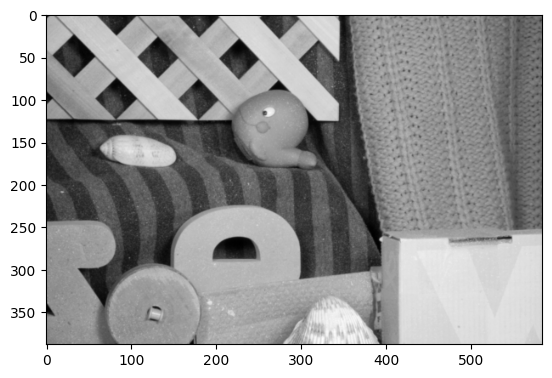

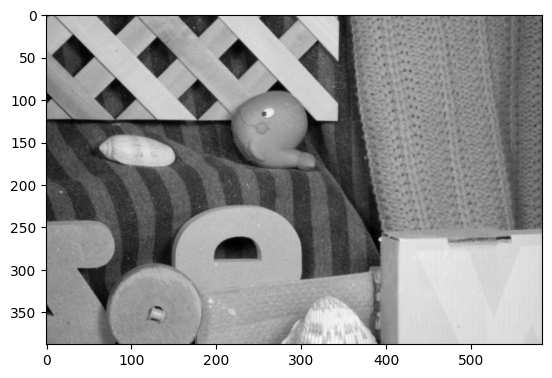

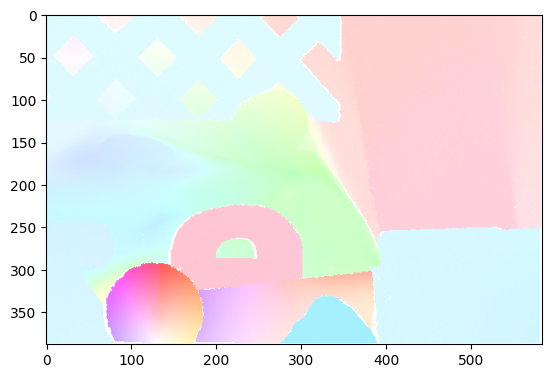

In [5]:
image1 = imread('frame1.png',as_gray=True)
image2 = imread('frame2.png',as_gray=True)
figure()
imshow(image1, cmap='gray')
figure()
imshow(image2, cmap='gray')

flow_gt = np.load('flow_gt.npy')
flow_image_gt = flow_vis.flow_to_color(flow_gt)
figure()
imshow(flow_image_gt, cmap='gray')

## Part A: Lukas-Knade Algorithm
We estimate the optical flow $u,v$ by solving the lineary system 
$$I_xu+I_yv+I_t=0$$

The spatial partial $I_x$ and $I_y$ derivatives are computed by correlating the patches with a 1D-kernel $[-1,1]$ and taking the average between the two patches (over images $I_1$, $I_2$). In order to make the estimates more robust, we furthermore smooth the derivatives with a 1D-kernel $\frac{1}{2}[1,1]$. These steps can be combined in a single correlation. For example the partial
derivative in x-direction between patches $I_1$ and $I_2$ is given by 

$$I_x = (I_1+I_2)*\frac{1}{4}\begin{bmatrix}-1 & 1\\ -1 & 1\end{bmatrix}$$

where $∗$ denotes the 2D correlation operator. Analogously, the partial temporal derivative is given by 

$$I_t = (I_2-I_1)*\frac{1}{4}\begin{bmatrix}1 & 1\\ 1 & 1\end{bmatrix}.$$

**Complete the missing lines to define the kernels and to compute the partial derivatives. You can use `signal.correlate2d(x, kernel, mode='same')` for correlation.** 

*Note: Here we use correlation rather than convolution to avoid flipping the kernel prior to filtering. However, in modern computer vision literature, the term convolution is often used to refer to what is technically the correlation operation in signal processing.*

After computing the partial derivatives, we can estimate the optical flow for each patch by solving the following linear system
$$A^TAx=A^Tb$$
with
$$A = \begin{bmatrix}p_x & p_y\end{bmatrix} \text{and } b = -p_t$$
**Complete the missing lines to define and solve the linear system. You can use `np.linalg.solve` to solve the linear system.** 


In [1]:
def lukas_kanade(I1, I2, window_size=5):
    
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1 = I1/255.  # normalize pixels
    I2 = I2/255.   # normalize pixels
    
    # Your codes here. Define convolution kernels.
    
    # Your codes here. Compute partial derivatives.
    
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)
    for i in range(w, I1.shape[0] - w):
        for j in range(w, I1.shape[1] - w):

            # obtain partial derivatives for current patch
            px = Ix[i - w:i + w + 1, j - w:j + w + 1].flatten()
            py = Iy[i - w:i + w + 1, j - w:j + w + 1].flatten()
            pt = It[i - w:i + w + 1, j - w:j + w + 1].flatten()
            
            # Your codes here. Compute optical flow.

    return u,v

**Now let's test the function.** The first plot shows the ground-truth and the second shows the estimation. The excution takes some time (~8s on laptops).

**Q: What is the influence of window size and why?**


The larger the window size, the coarser the optical flow. Fine movement is lost in favor of bigger movement.

max flow: 9.5809 flow range: u = -3.536 .. 5.516; v = -7.135 .. 9.328

Elaspsed time:  2.357766628265381


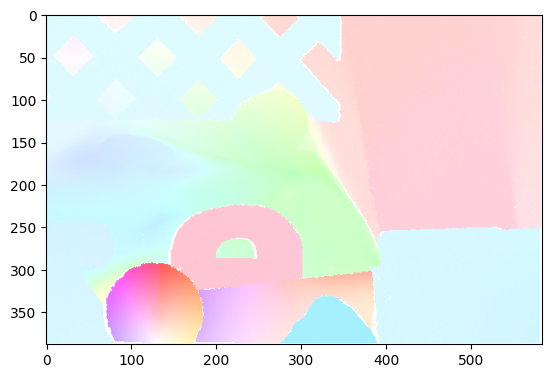

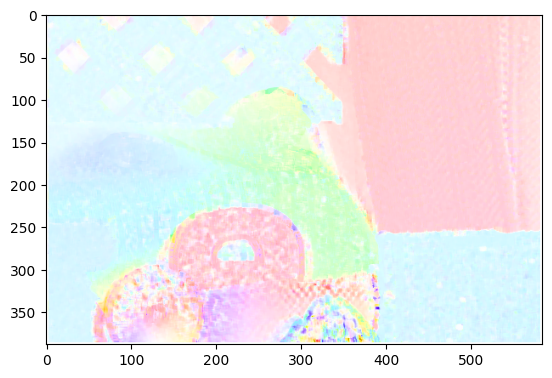

In [13]:
t = time.time()

u, v = lukas_kanade(image1, image2, window_size=5)

figure()
imshow(flow_image_gt, cmap='gray')

figure()
flow_image = flow_vis.flow_to_color(np.stack([u,v],axis=-1))
imshow(flow_image,cmap='gray')

print('Elaspsed time: ', time.time()-t)

## Part B: Lukas-Kanade with Pyramid

In previous part, the optical flow of each pixel is computed only based on a small neighbouring region. Therefore the algorithm cannot deal with large displacement. As a solution, we can apply the algorithm iteratively from coarse to fine.

We construct a image pyramid, apply the optical flow algorithm at each level starting from the coarsest resolution and propagate the computed flow to the next level. The propagation is done by first warping image1 with the estimated flow and then estimate the residual flow between the image2 and warped image1. You can use `ndimage.map_coordinates(image1, [ys, xs])` for image warping.

**Note:**
* The name of `map_coordinates' can be quite misleading. In fact it does **not** forward-warp the pixels in the source image to [ys, xs] in the target image. Instead, it composits the target image by sampling the source image using coordinates [ys,xs]. You can understand this better using the example below.
* In our case, the flow from image1 to image2 is exactly the negation of the flow from image2 to image1. Why?

In [ ]:
source_img = np.array([[1,2],
                       [3,4]])
ys, xs = [0,1],[0,0]
#Warped image contains two pixels, which come from (y,x)=(0,0), (1,0) in the source_img
print(ndimage.map_coordinates(source_img,[ys,xs]))

ys = [[1,0],[1,0]]
xs = [[1,0],[0,1]] #warped image contains 2x2 pixels. They come from (1,1), (0,0), (1,0), (0,1) in the source image.
print(ndimage.map_coordinates(source_img,[ys,xs]))

h, w = 10,10
source_img = np.random.randn(h,w)
figure()
imshow(source_img, cmap='gray', vmin=0, vmax=1)
#Target img: shift source_img to the right by 2. Then the flow from target to source is (-2,0)
ys, xs = np.mgrid[:h, :w]
xs -= 2
target_img = ndimage.map_coordinates(source_img,[ys,xs])
figure()
imshow(target_img, cmap='gray', vmin=0, vmax=1)

**Complete the following lines for image warping and optical flow estimation & updating.**

max flow: 1.2891 flow range: u = -0.316 .. 0.574; v = -1.289 .. 1.009

max flow: 3.1023 flow range: u = -1.678 .. 3.099; v = -2.177 .. 1.056

max flow: 8.3171 flow range: u = -3.126 .. 8.316; v = -2.537 .. 3.142

max flow: 16.0448 flow range: u = -6.344 .. 16.043; v = -8.751 .. 5.697



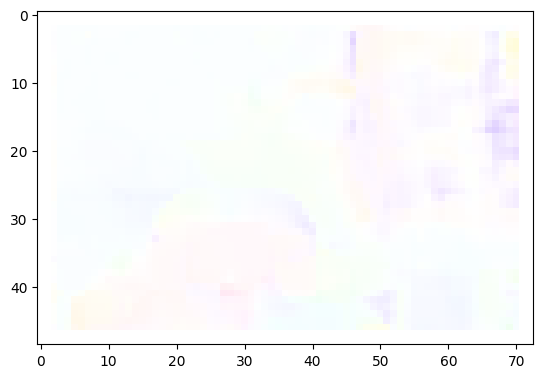

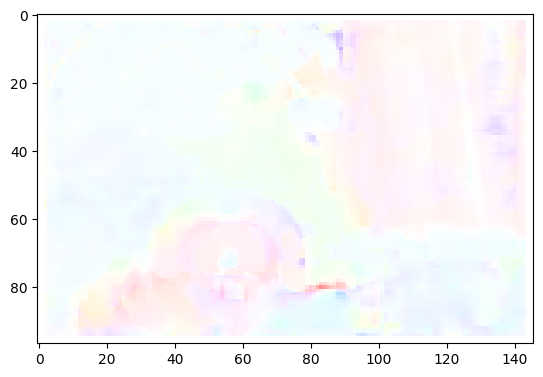

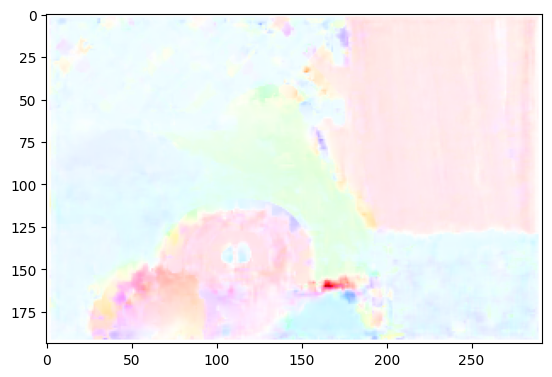

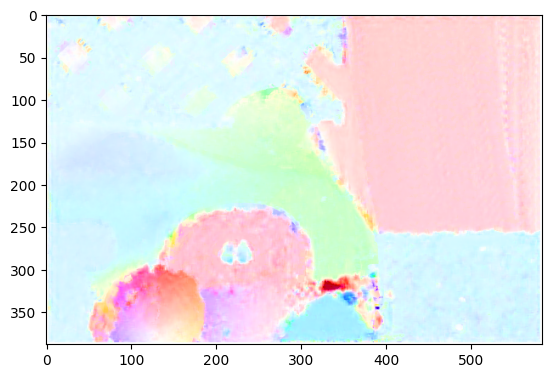

In [41]:
num_layers = 3
downscale = 2

# Construct image pyramids
pyramids1 = tf.pyramid_gaussian(image1, max_layer=num_layers, downscale=downscale, sigma=1, channel_axis=None)
pyramids2 = tf.pyramid_gaussian(image2, max_layer=num_layers, downscale=downscale, sigma=1, channel_axis=None)

u = np.zeros(image1.shape)
v = np.zeros(image1.shape)

for im1,im2 in zip(reversed(list(pyramids1)),reversed(list(pyramids2))):

    h,w = im1.shape

    u = h/u.shape[0] * tf.resize(u, (h,w), order=1)
    v = h/u.shape[0] * tf.resize(v, (h,w), order=1)

    # Warp image.

    # Update optical flow.

    flow_image = flow_vis.flow_to_color(np.stack([u,v],axis=-1))
    figure()
    imshow(flow_image,cmap='gray')

## Part C: Frame Extrapolation with Optical Flow

Optical flow can be used for frame extrapolation. Given the two frames, we can predict the next few frames (assuming constant pixel motions). This can be done by scaling the optical flow and warping the image accordingly. 

**Complete the following lines for frame extrapolation.**

**Q: what do you need to change to make it a frame interpolation algorithm?**

A: change `i` from $[1,10]$ to $[0, 1]$

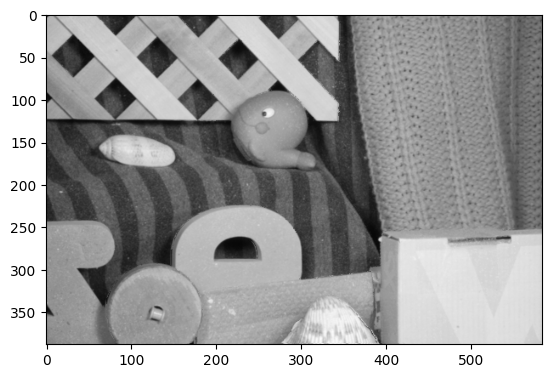

In [51]:
h,w = image1.shape[:2]
yy, xx = np.mgrid[:h, :w]
flow = np.stack([u,v],axis=-1)
for i in range(1,10):
    
    # Extrapolate the next 10 frames, using the flow between img1 and img2 as one step.

    image1_warp = ndimage.map_coordinates(image1, [rows, cols])
    imshow(image1_warp,cmap='gray')
    
    IPython.display.clear_output(True)
    show()

# Part D: Exam question
![alt](Q1.png)
![alt](A1.png)
![alt](Q2.png)
![alt](A2.png)
![alt](Q3.png)
![alt](A3.png)